# Machine Learning Algorithms with GTZAN dataset 

This notebook plays around with the ML algorithms we can use for music classification, to form a baseline for deep learning models. 

Commonly used words: 

Pitch - how high or low a note is.   
Loudness - how loud or soft a sound is.  
Timbre - the color or quality of a sound.  
Attack - how quickly a sound reaches its peak amplitude.  
Decay - how quickly a sound fades away.  

## About GTZAN 

Collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recording - different levels of kHz most likely. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00005.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00057.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00020.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00072.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00040.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00043.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00010.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco/disco00071.png
/kaggle/input/gtzan-dataset-music-genre-classification/Data/image

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

In [3]:
# List genres 
general_path = Path("../input/gtzan-dataset-music-genre-classification/Data/genres_original")
# print(list(general_path.iterdir()))
genres = [path.name for path in general_path.iterdir()] # .name gets the final path component without the whole path 
print(genres)

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


## Librosa Load 

Gives back audio time-series as numpy array and the sampling rate. 

Default is all audio is resampled at 22050 Hz - can change this. 

Sound: sequence of vibrations in varying pressure strengths (y). 

Sampling rate: The number of samples carried per second. Higher sampling rate will result in more frequent lines in librosa plots. 

If sampling rate is 22,050 Hz, then array length is around 661,000. If it is 48,000, then array length is around 1,5 million. This is for music samples around 30 seconds. 

$$
Audio length = \frac{array length}{sampling rate}
$$

Because of this equation, increasing/decreasing the sampling rate increases/decreases the length of the audio file + how fast/slow it plays. 

In [4]:
# Explore audio data 
# Librosa takes .wav files and turns them into arrays 
y, sr = librosa.load(f'{general_path}/reggae/reggae.00036.wav')

print(f"{y=} \n")
print(f"y shape={np.shape(y)} \n")
print(f"Sample rate (kHz)={sr} \n")

print(f"Length of audio is array length divided by sampling rate= {len(y)/sr}")

y=array([0.02072144, 0.04492188, 0.05422974, ..., 0.06912231, 0.08303833,
       0.08572388], dtype=float32) 

y shape=(661794,) 

Sample rate (kHz)=22050 

Length of audio is array length divided by sampling rate= 30.013333333333332


In [31]:
# Quickly play the audio files in Python
ipd.Audio(data=y,rate=sr)

In [5]:
# Import a rock song 
y_rock,sr_rock = librosa.load(f"{general_path}/rock/rock.00024.wav")

print(f"{y_rock=}")
print(f"y shape={np.shape(y_rock)}")
print(f"sampling rate={sr_rock}")

ipd.Audio(data=y_rock,rate=sr_rock)

y_rock=array([-0.09228516, -0.20037842, -0.27676392, ..., -0.1456604 ,
       -0.30737305, -0.37786865], dtype=float32)
y shape=(661794,)
sampling rate=22050


In [6]:
# Import a metal song 
y_metal, sr_metal = librosa.load(f"{general_path}/metal/metal.00011.wav")

print(f"{y_metal=}")
print(f"y shape={np.shape(y_metal)}")
print(f"sampling rate={sr_metal}")

ipd.Audio(data=y_metal,rate=sr_metal)

y_metal=array([-0.05050659,  0.26184082,  0.3322754 , ...,  0.14788818,
        0.21975708,  0.08520508], dtype=float32)
y shape=(661504,)
sampling rate=22050


In [7]:
# Import a country song 
y_country, sr_country = librosa.load(f"{general_path}/country/country.00029.wav")

ipd.Audio(data=y_country,rate=sr_country)

# Feature Extraction with Transformations 

Below are commonly-used transformations in audio signals. An effective ML might combine features extracted from multiple transformations (CQT, STFT, Mel Spectogram) for better classification results. 

STFT/Mel Spectograms: capturing broad spectral and temporal features.   
CQT: add detailed insights into the musical content. Measures the energy in each pitch.

Spectral features: analyze harmony or timbre. 

Chroma: measures the energy in each pitch class. 

## Broad Classification of Features 

**Spectral Features** 

Characteristics of the sound that can be derived from its frequency spectrum (different frequencies that make up the sound and their intensities). Spectral features capture aspects of a sound's timbre, pitch, harmony, and texture. 

1. Spectral Centroid: Center of mass of the spectrum. Brightness of a sound. Higher values = brighter, more treble-heavy sound. 
2. Spectral Bandwidth: The width of the spectrum around its centroid. Quantify sound's spread. Amount of noise, complexity of a sound. 
3. Spectral Roll-off: The freq below which a certain % of the total energy of the spectrum is contained. Distinguish between harmonic (musical tone) and noise-like components of the sound. 
3. Spectral Flatness: Measures how noise-like a sound is. Flat (energy is spread evenly across frequencies) = noise, peaks = tonal. 
4. Spectral Contrast: Difference in amplitude between peaks and valleys, presence of strong harmonic content versus noise. 
5. Mel-Frequency Cepstral Coefficients (MFCC): Short-term power spectrum of a sound in a way that mimics human auditory perception more closely than linearly-spaces frequency bands. 

**Temporal Features** 

Relate to the time-domain aspects of sound: zero-crossing rate(the rate at which the signal changes sign), tempo. 

**Rhythm Features** 

Extracted from the temporal structure of the music: beat, tempo, rhythm patterns, time signature detection. 

**Harmonic Features** 

Analysis of chords and harmonies: chord deterction, key detection, tonal analysis

**Timbral Features** 

Sound texture and quality: attack time and decay. 

**Perceptral Features** 

Human perceptions: loudness, sharpness, warmth of a sound. 



## Waveforms

Librosa library allows you to look at waveforms, but people do not really recommend looking into these (although we talked about potential ways to use these graphs). 

Text(0.5, 1.0, 'Country')

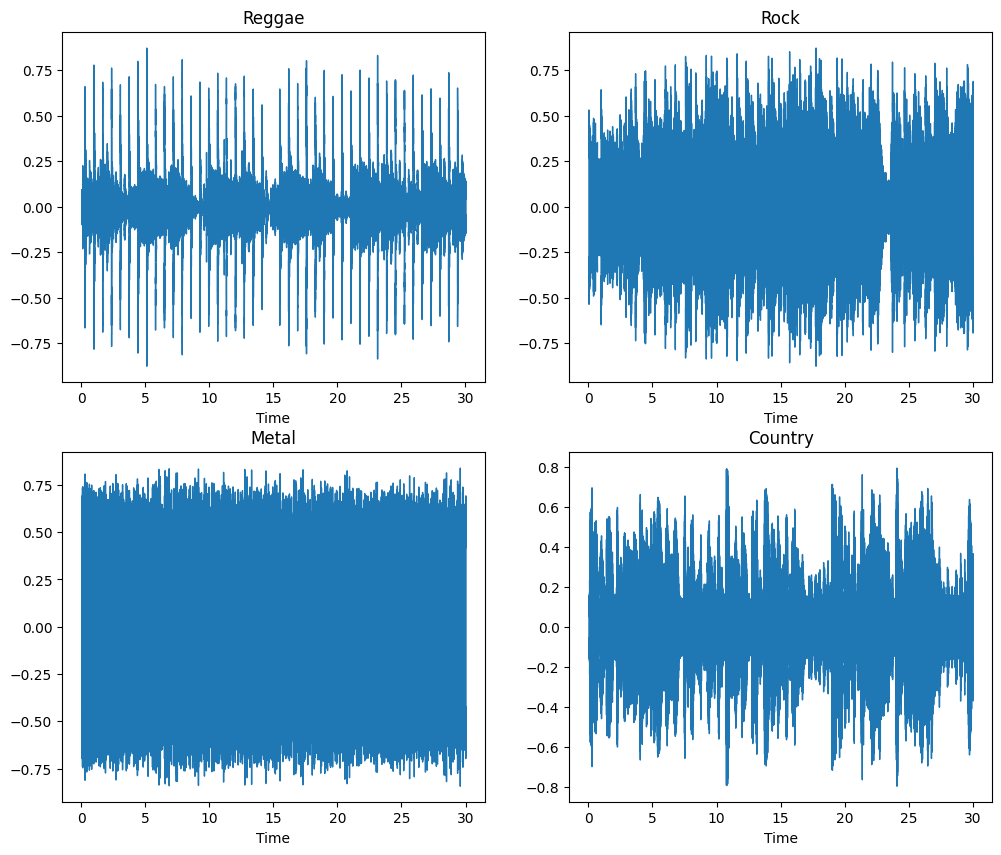

In [60]:
# Librosa Plotting y array 
fig, ax= plt.subplots(2,2,figsize=(12,10))

librosa.display.waveshow(y, ax=ax[0,0])
ax[0,0].set_title("Reggae")

librosa.display.waveshow(y_rock, ax=ax[0,1])
ax[0,1].set_title("Rock")

librosa.display.waveshow(y_metal, ax=ax[1,0])
ax[1,0].set_title("Metal")

librosa.display.waveshow(y_country, ax=ax[1,1])
ax[1,1].set_title("Country")

## Spectograms 

How the audio spectrum varies as a function of time. 

2-D Numpy arrays - frequency, time 

frame= short audio clip (spectogram column) - short snippet of a signal 

n_fft = samples per frame 

hop_length = how far you move the frame with each column of the spectogram - # samples between frames 

### Short-time Fourier Transform (STFT) 

FT transforms a signal from time domain into frequency domain, revealing the different frequencies that make up the signal. 

With music and speech, frequencies change over time and applying Ft all at once wouldn't work. 

So we use STFT to be able to see which frequencies are present and how they change over time. 

1) Divide the signal into short segments (frames).

2) Perform FT on each segment, 

Defaults: 

sr: 22050   
n_fft: 2048  - trade-off between frequency resolution and time. With more points, you can distinguish frequencies better but harder to relocate changes over time. 
hop_length: 512 - how many samples you skip before starting a new STFT frame. Small values better resolution, but increases computational load. 



In [8]:
# STFT 
D = librosa.stft(y)
D # result is a 2d array 

array([[ 3.47488642e-01+0.0000000e+00j, -8.03473964e-02+0.0000000e+00j,
         5.23666218e-02+0.0000000e+00j, ...,
        -1.11128904e-01+0.0000000e+00j, -6.03751123e-01+0.0000000e+00j,
        -3.44821692e+00+0.0000000e+00j],
       [-3.25866848e-01-5.3659570e-01j,  2.41293266e-01+1.7580320e-01j,
         8.47926512e-02-4.8197523e-02j, ...,
        -9.89066809e-02-7.3352322e-02j, -4.78028774e-01-4.4539994e-01j,
         2.71772718e+00-2.5260990e+00j],
       [ 2.50797331e-01+1.6455048e+00j,  4.63563383e-01-4.0656266e-01j,
         1.61637336e-01-1.0312595e-01j, ...,
        -2.67529070e-01-3.5789585e-01j, -2.26537153e-01-9.5394200e-01j,
        -9.64135528e-02+4.0366755e+00j],
       ...,
       [ 1.15957193e-03-2.2124217e-04j, -3.53455282e-04+3.9262322e-04j,
        -3.03704408e-04-2.6268329e-04j, ...,
         1.43483412e-05+2.6095651e-05j, -7.80400180e-04+3.6981597e-03j,
         5.63846249e-03-2.7578225e-02j],
       [-1.08170754e-03+3.3590823e-05j, -1.63719975e-04+4.6538323e-0

### What is going on in the code below? 

The old code was logamplitude (in comments). We are taking the 2d-array spectogram, taking the power of it to create a power spectogram, showing the power of different frequencies present in the signal at each point in time. 

Then we convert power spectogram into logarithmic scale because human perception of sound intensity is logarithmic, not linear. We also scale the whole thing by the maximum sound we hear throughout the audio piece. 

But in the new version, we use power_to_db, which converts power spectogram to decibel scale. Decibel scale is a logarithmic scale to measure sound intensity. 

Side Note: For a sound to be perceived as roughly twice as loud, the sound intensity needs to increase by about 10 dB (tenfold increase(. 

Highest power is set to 0 dB and other values are relative to this highest power, assuming negative values. This is closer to how humans hear and perceive sounds and this conversion is important for feature extraction, noise reduction etc. 

Whispering is around 30 dB, normal conversation is 60 dB, a rock concert can be over 120 dB. My Apple watch gives a loud environment warning when the surrounding sound is around 90 dB. :) 


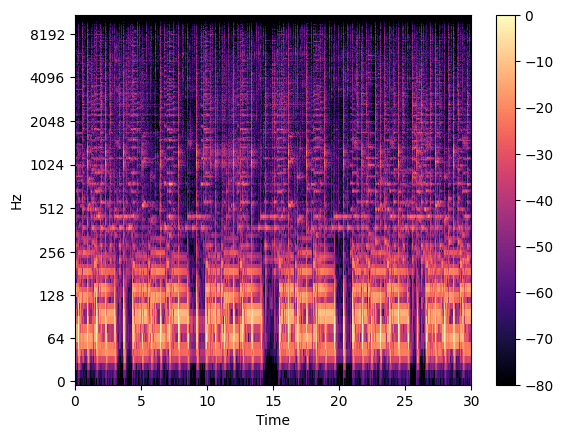

In [14]:
# Display spectograms 

# The following code transforms the spectogram (2d-array) to its log-power transformation - power spectogram
#log_power = librosa.logamplitude(D**2, ref_power=np.max)
log_power = librosa.power_to_db(D**2, ref=np.max)

librosa.display.specshow(log_power, x_axis="time",
                         y_axis="log") # if linear, all action is below the graph, so we plot on log-scale
plt.colorbar()

## Constant-Q Transform 

Divides the frequency axis into bins that are geometrically spaced, meaning each bin's width is proportional to its center frequency.  Higher frequency resolution at lower frequencies and lower frequency resolution at higher frequencies. Used in tasks that require identifying musical notes, chords, and harmonics. 

More computationally intensive than STFT. 

For audio classification tasks, Constant-Q Transformation is more relevant. Captures musical notes and harmonies, chord progression, bass lines (finer precision at lower frequencies), harmonic content. 

Features derived from constant-q transform for audio classification: harmonic patterns, note density, temporal changes in pitch 





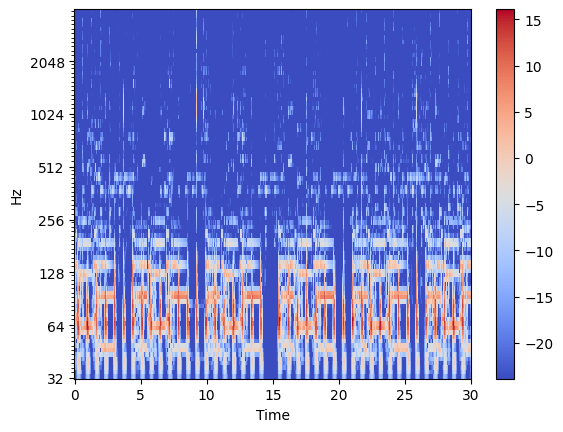

In [22]:
# CQT 
C = librosa.cqt(y,sr=sr) # logarithmic-spaced representation 

librosa.display.specshow(librosa.power_to_db(C**2,
                                            top_db=40),
                          x_axis="time",
                          y_axis="cqt_hz")
plt.colorbar()

## Chroma 

Energy in each pitch class. 

Pitch refers to the perceived frequency of a sound, determining how high or low it sounds to the human ear. 

At C-major scale, Do is the root note of the scale. 

C= Do  
D= Re  
E= Mi  
F= Fa   
G= Sol  
A= La  
B= Si

A pitch is a discrete tone with an individual frequency (C4) whereas a pitch class is the broad class (C). 

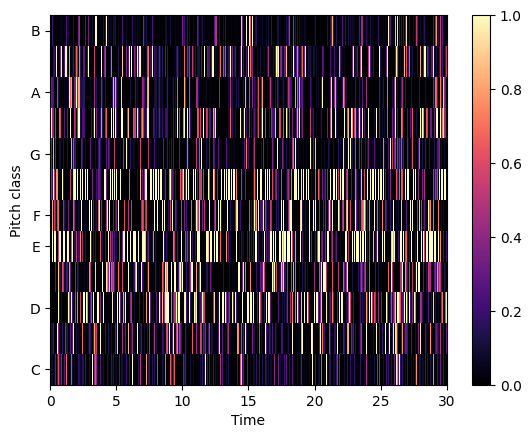

In [26]:
# Chroma - energy in each pitch class 

chroma = librosa.feature.chroma_cqt(C=C,sr=sr)
librosa.display.specshow(chroma,x_axis="time",
                        y_axis="chroma")
plt.colorbar()

## Other Spectral Features

Librosa.feature module allows you to automatically calculate these. 

Mel Spectogram: Visual representation of the audio signal that combines the Mel scale with the traditional spectogram. It starts with a spectogram which is calculated using STFT. The frequencies are mapped onto the Mel scale (a perceptual scale of pitches). 

MFCC: Mel-Frequency Cepstral Coefficients. Apply a Discrete Cosine Transform to the log-mel spectogram. Set of coefficients that compactly represent the audio signal. Typically, the first 12-13 coefficients are used because they capture the most information. 

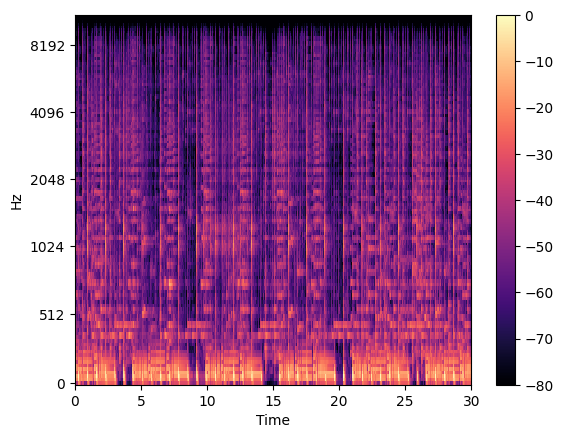

In [50]:
# Mel-Spectogram of Reggae
M = librosa.feature.melspectrogram(y=y,sr=sr)

librosa.display.specshow(librosa.power_to_db(M,ref=np.max),x_axis="time",
                       y_axis="mel")
plt.colorbar()

In [43]:
# Mel-Spectogram of Different Genres
M_rock = librosa.feature.melspectrogram(y=y_rock,sr=sr_rock)
M_metal = librosa.feature.melspectrogram(y=y_metal,sr=sr_metal)
M_country = librosa.feature.melspectrogram(y=y_country,sr=sr_country)


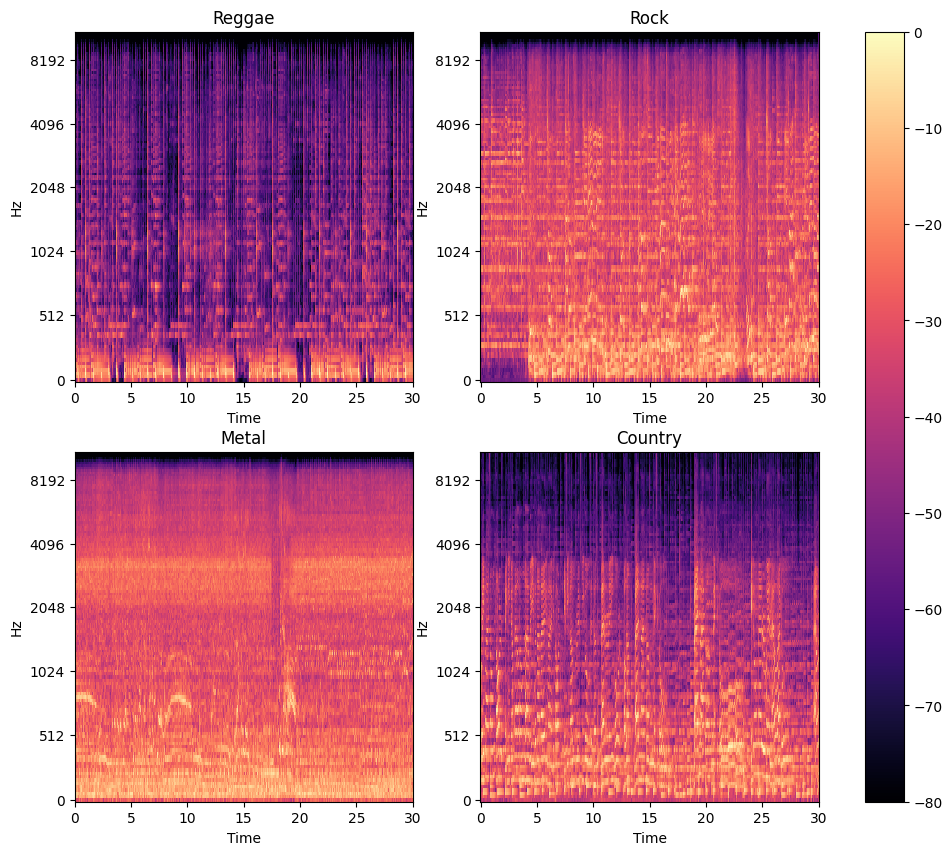

In [48]:
# Librosa Plotting y array 
fig, ax= plt.subplots(2,2,figsize=(12,10))

img = librosa.display.specshow(librosa.power_to_db(M,ref=np.max),x_axis="time",
                       y_axis="mel", ax=ax[0,0])

ax[0,0].set_title("Reggae")

librosa.display.specshow(librosa.power_to_db(M_rock,ref=np.max),x_axis="time",
                       y_axis="mel", ax=ax[0,1])
ax[0,1].set_title("Rock")

librosa.display.specshow(librosa.power_to_db(M_metal,ref=np.max),x_axis="time",
                       y_axis="mel", ax=ax[1,0])
ax[1,0].set_title("Metal")

librosa.display.specshow(librosa.power_to_db(M_country,ref=np.max),x_axis="time",
                       y_axis="mel", ax=ax[1,1])
ax[1,1].set_title("Country")

fig.colorbar(img,ax=ax)

plt.show()